In [229]:
# -*- coding: utf-8 -*-
%matplotlib inline
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [230]:
# Read recipe inputs
transactions_known_scored = dataiku.Dataset("transactions_known_scored").get_dataframe(limit=1000)

In [242]:
list_var = ['authorized_flag','proba_1']
transactions_known_scored = transactions_known_scored[list_var]
transactions_known_scored['decile'] = pd.cut(x=transactions_known_scored.proba_1,
                                             bins=10, precision=1, right=False)
transactions_known_scored.decile = transactions_known_scored.decile.astype(str)

In [243]:
transactions_known_scored.tail()

,authorized_flag,proba_1,decile
995,0,0.378797,"[0.37, 0.45)"
996,1,0.456347,"[0.45, 0.52)"
997,1,0.568417,"[0.52, 0.6)"
998,1,0.458323,"[0.45, 0.52)"
999,1,0.429150,"[0.37, 0.45)"


In [244]:
transactions_known_scored.decile.value_counts()

[0.45, 0.52)    252
[0.37, 0.45)    234
[0.91, 0.99)    112
[0.83, 0.91)     86
[0.68, 0.76)     84
[0.76, 0.83)     77
[0.52, 0.6)      58
[0.6, 0.68)      48
[0.29, 0.37)     40
[0.21, 0.29)      9
Name: decile, dtype: int64

In [234]:
col_names = {'authorized_flag':'sum_true', 'proba_1':'count_pred'}
df_by_deciles = transactions_known_scored.groupby(by='decile').agg({'authorized_flag':'sum',
                                                                    'proba_1':'count'}).rename(columns=col_names)

In [235]:
df_by_deciles['validation_ratio'] = df_by_deciles.sum_true/df_by_deciles.count_pred
df_by_deciles.sort_index(ascending=True, inplace=True)

In [245]:
df_by_deciles

,sum_true,count_pred,total,validation_ratio
decile,,,,
"[0.21, 0.29)",4,9,13,0.307692
"[0.29, 0.37)",25,40,65,0.384615
"[0.37, 0.45)",183,234,417,0.438849
"[0.45, 0.52)",219,252,471,0.464968
"[0.52, 0.6)",50,58,108,0.462963
"[0.6, 0.68)",43,48,91,0.472527
"[0.68, 0.76)",81,84,165,0.490909
"[0.76, 0.83)",77,77,154,0.500000
"[0.83, 0.91)",86,86,172,0.500000


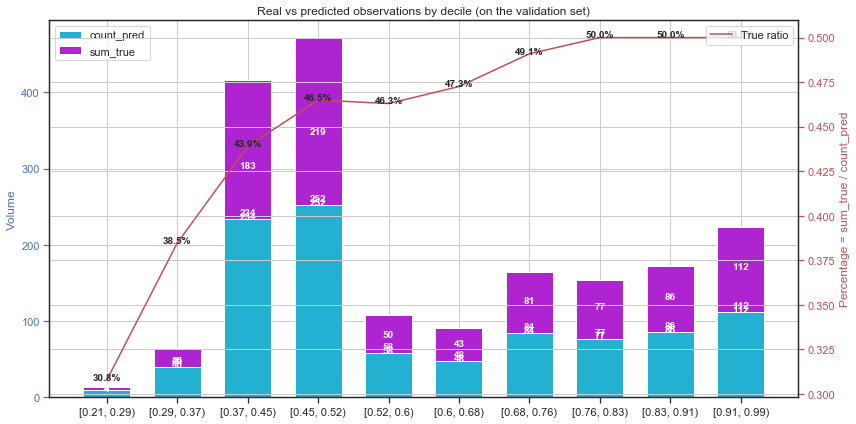

In [247]:
sns.set_style("ticks",{'axes.grid' : True})
colors = ['#24b1d1', '#ae24d1']
labels = list(df_by_deciles.index)
sum_true = list(df_by_deciles.sum_true)
count_pred = list(df_by_deciles.count_pred)
validation_ratio = list(df_by_deciles.validation_ratio)
width = 2/3 # the width of the bars

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.bar(labels, count_pred, width, label='count_pred', color=colors[0])
ax1.bar(labels, sum_true, width, bottom=count_pred, label='sum_true', color=colors[1])
color = 'b'
ax1.set_ylabel('Volume', color=color)
ax1.tick_params('y', colors=color)
ax1.legend(loc='upper left')

# Set an offset that is used to bump the label up a bit above the bar.
y_offset = 5
# Add total value to each bar.
for i, total in enumerate(df_by_deciles.count_pred):
    ax1.text(df_by_deciles.count_pred.index[i], total + y_offset, '{:,}'.format(round(total)), 
             ha='center', weight='bold', color='w')

# For each patch (basically each rectangle within the bar), add a label.
for bar in ax1.patches:
    ax1.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_height() + bar.get_y() / 2,
      # This is actual value we'll show.
      #round(bar.get_height()),
      '{:,}'.format(round(bar.get_height())),
      # Center the labels and style them a bit.
      ha='center',
      color='w',
      weight='bold',
      size=10
    )
    
    
ax2 = ax1.twinx()
color = 'r'
ax2.plot(labels, validation_ratio, label='True ratio', color=color)
ax2.set_ylabel('Percentage = sum_true / count_pred', color=color)
ax2.tick_params('y', colors=color)
ax2.legend(loc='upper right')

# Add ratio value to each bar.
for i, ratio in enumerate(validation_ratio):
    ax2.text(df_by_deciles.validation_ratio.index[i], ratio, '{:,.1%}'.format(ratio), ha='center', weight='bold')

plt.title('Real vs predicted observations by decile (on the validation set)')
fig.tight_layout()
plt.show()

In [0]:
## Vérifier qu'on a les bons volumes (somme notamment) et commencer une review à présenter
## Dans quelle table le mettre
## Subject matter: all kind of binary classification (such as churn or engagement scoring)

In [130]:
# Save plot to folder
folder_for_plot = dataiku.Folder("ofSVU3Pe")
folder_path = folder_for_plot.get_path()

path_fig = os.path.join(folder_path, "output.png")
plt.savefig(path_fig)

<Figure size 432x288 with 0 Axes>